# 이상 거래 분석 시스템

## 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix

# Display settings
plt.style.use('ggplot')
sns.set(style='whitegrid')

## 2. Load and Explore Dataset

In [2]:
# Load the datasets
train_transaction = pd.read_csv('data/train_transaction.csv')
test_transaction = pd.read_csv('data/test_transaction.csv')
train_identity = pd.read_csv('data/train_identity.csv')
test_identity = pd.read_csv('data/test_identity.csv')

In [3]:
# Display the first few rows of each dataset
print("Train Transaction Data:")
print(train_transaction.head())

print("\nTest Transaction Data:")
print(test_transaction.head())

print("\nTrain Identity Data:")
print(train_identity.head())

print("\nTest Identity Data:")
print(test_identity.head())

Train Transaction Data:
   TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5  ... V330  V331  V332  V333  V334 V335  \
0    NaN  150.0    discover  142.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
1  404.0  150.0  mastercard  102.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
2  490.0  150.0        visa  166.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
3  567.0  150.0  mastercard  117.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
4  514.0  150.0  mastercard  102.0  ...  0.0   0.0   0.0   0.0   0.0  0.0   

  V336  V337  V338  V339  
0  NaN   NaN   NaN   Na

In [4]:
# Display basic information about each dataset
print("Train Transaction Info:")
print(train_transaction.info())

print("\nTest Transaction Info:")
print(test_transaction.info())

print("\nTrain Identity Info:")
print(train_identity.info())

print("\nTest Identity Info:")
print(test_identity.info())

Train Transaction Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 1.7+ GB
None

Test Transaction Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506691 entries, 0 to 506690
Columns: 393 entries, TransactionID to V339
dtypes: float64(376), int64(3), object(14)
memory usage: 1.5+ GB
None

Train Identity Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  144233 non-null  int64  
 1   id_01          144233 non-null  float64
 2   id_02          140872 non-null  float64
 3   id_03          66324 non-null   float64
 4   id_04          66324 non-null   float64
 5   id_05          136865 non-null  float64
 6   id_06          136865 non-null  float64
 7   id_07          5155 non-n

In [5]:
# Check for missing values in the datasets
missing_values_train_transaction = train_transaction.isnull().sum()
missing_values_train_identity = train_identity.isnull().sum()
print("Missing values in train_transaction:\n", missing_values_train_transaction[missing_values_train_transaction > 0])
print("Missing values in train_identity:\n", missing_values_train_identity[missing_values_train_identity > 0])

Missing values in train_transaction:
 card2      8933
card3      1565
card4      1577
card5      4259
card6      1571
          ...  
V335     508189
V336     508189
V337     508189
V338     508189
V339     508189
Length: 374, dtype: int64
Missing values in train_identity:
 id_02           3361
id_03          77909
id_04          77909
id_05           7368
id_06           7368
id_07         139078
id_08         139078
id_09          69307
id_10          69307
id_11           3255
id_13          16913
id_14          64189
id_15           3248
id_16          14893
id_17           4864
id_18          99120
id_19           4915
id_20           4972
id_21         139074
id_22         139064
id_23         139064
id_24         139486
id_25         139101
id_26         139070
id_27         139064
id_28           3255
id_29           3255
id_30          66668
id_31           3951
id_32          66647
id_33          70944
id_34          66428
id_35           3248
id_36           3248
id_37      

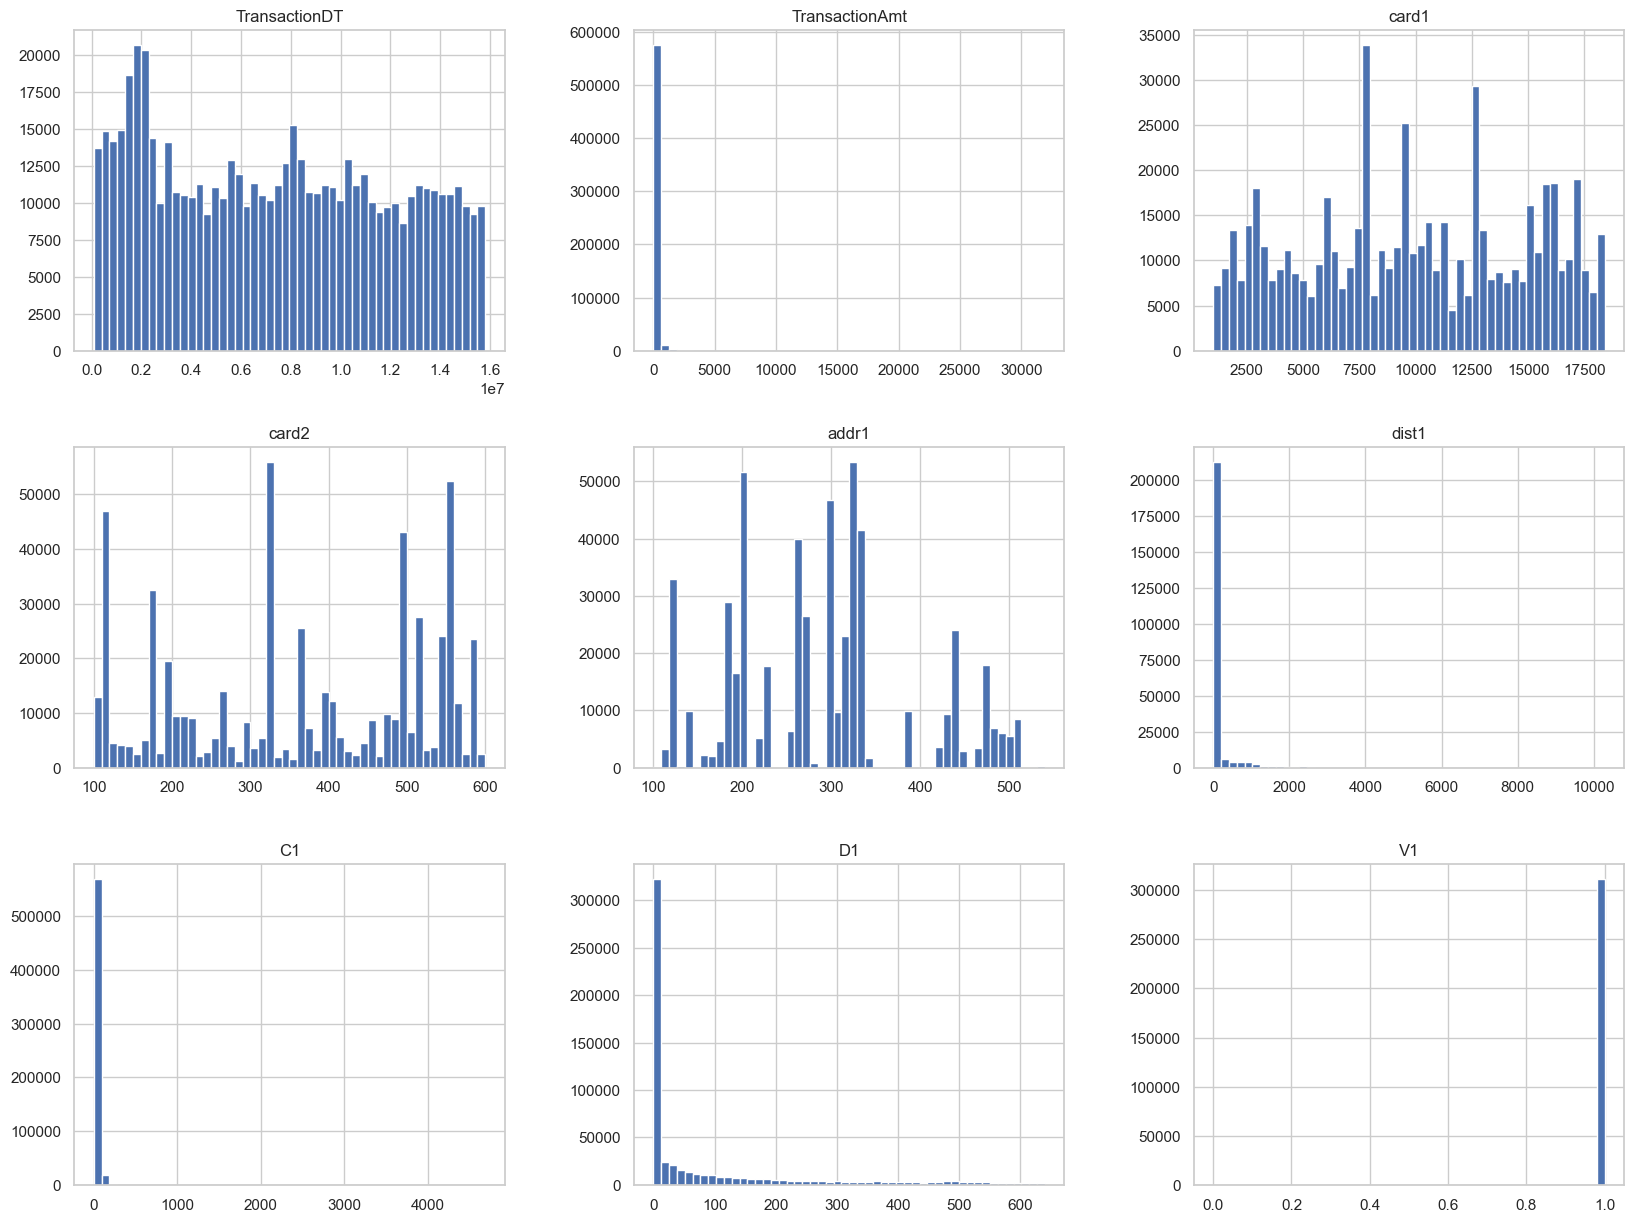

In [6]:
# Visualize the distribution of selected features in train_transaction
selected_features = ['TransactionDT', 'TransactionAmt', 'card1', 'card2', 'addr1', 'dist1', 'C1', 'D1', 'V1']
train_transaction[selected_features].hist(bins=50, figsize=(20, 15))
plt.show()

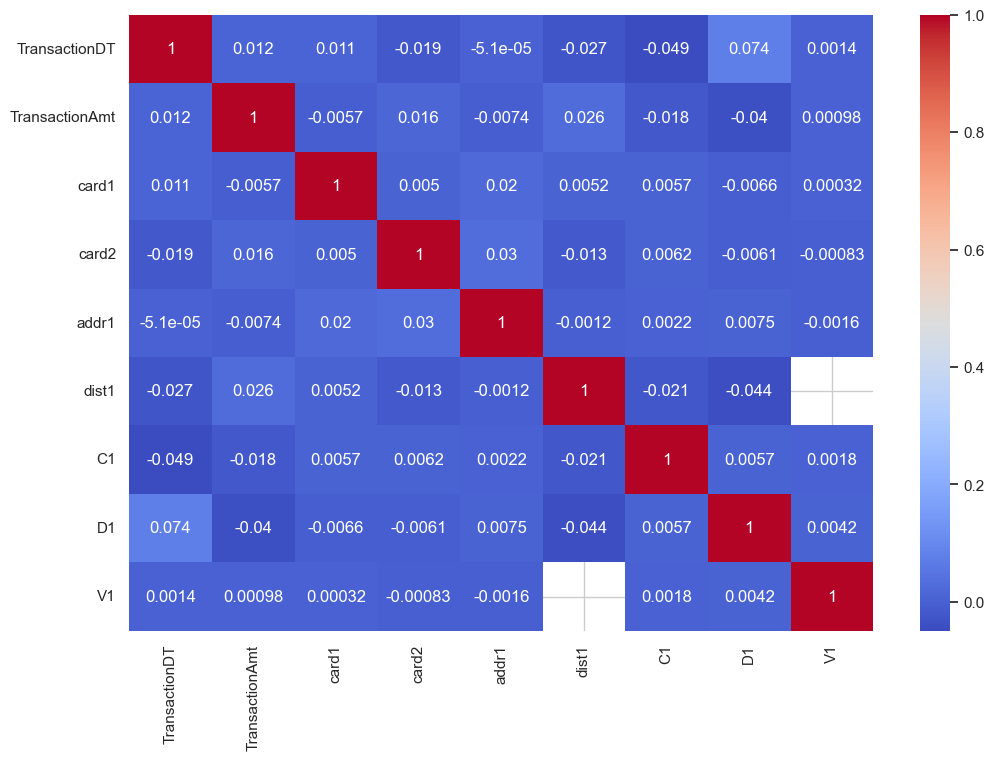

In [7]:
# Visualize the correlation matrix for selected features in train_transaction
selected_features = ['TransactionDT', 'TransactionAmt', 'card1', 'card2', 'addr1', 'dist1', 'C1', 'D1', 'V1']
correlation_matrix = train_transaction[selected_features].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()